<a href="https://colab.research.google.com/github/bofori-tech/DS-Unit-2-Applied-Modeling/blob/master/Build_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

In [49]:
 #https://www.kaggle.com/hugomathien/soccer/download

In [2]:
!unzip archive.zip

Archive:  archive.zip
  inflating: database.sqlite         


In [3]:
import pandas as pd
import numpy as np
import sqlite3
# pd.read_sql("./database.sqlite")
con = sqlite3.connect("./database.sqlite")

In [4]:
df_Country = pd.read_sql(sql="SELECT * FROM Country", con=con)
df_League = pd.read_sql(sql="SELECT * FROM League", con=con)
df_Match = pd.read_sql(sql="SELECT * FROM Match", con=con)
df_Player = pd.read_sql(sql="SELECT * FROM Player", con=con)
df = pd.read_sql(sql="SELECT * FROM Player_Attributes", con=con)
df_Team = pd.read_sql(sql="SELECT * FROM Team", con=con)
df_Team_Attributes = pd.read_sql(sql="SELECT * FROM Team_Attributes", con=con)

In [5]:
df.head()
print(df.shape)

(183978, 42)


In [6]:
pd.to_datetime(df["date"]).sort_values()

183977   2007-02-22
79627    2007-02-22
79620    2007-02-22
79610    2007-02-22
79579    2007-02-22
            ...    
57229    2016-07-07
1329     2016-07-07
153508   2016-07-07
19675    2016-07-07
95620    2016-07-07
Name: date, Length: 183978, dtype: datetime64[ns]

In [7]:
df['overall_rating'].value_counts()

68.0    10492
69.0    10281
67.0    10198
66.0    10112
70.0    10028
        ...  
38.0        8
35.0        5
36.0        3
37.0        3
33.0        2
Name: overall_rating, Length: 61, dtype: int64

In [8]:
df['overall_rating'].describe()

count    183142.000000
mean         68.600015
std           7.041139
min          33.000000
25%          64.000000
50%          69.000000
75%          73.000000
max          94.000000
Name: overall_rating, dtype: float64

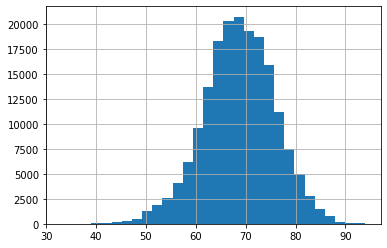

In [9]:
df['overall_rating'].hist(bins=30);

In [10]:
df = df.dropna(subset=['overall_rating'])
df['Good'] = df['overall_rating'] >=70

In [11]:
# There are 2 classes, this is a binary classification problem. 
y = df['Good']
y.nunique()

2

In [12]:
y.value_counts(normalize=True)

False    0.54574
True     0.45426
Name: Good, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


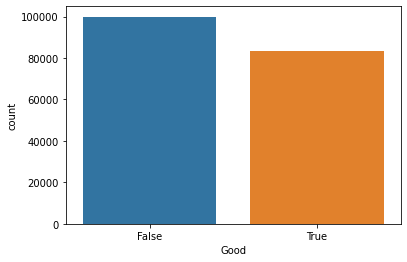

In [13]:
# display that as a graphic.
import seaborn as sns
sns.countplot(y);

In [14]:
# Count the missing values
df.isna().sum().sort_values()

id                        0
gk_reflexes               0
reactions                 0
shot_power                0
stamina                   0
strength                  0
long_shots                0
aggression                0
sprint_speed              0
interceptions             0
penalties                 0
marking                   0
standing_tackle           0
gk_diving                 0
gk_handling               0
gk_kicking                0
gk_positioning            0
positioning               0
acceleration              0
Good                      0
long_passing              0
player_fifa_api_id        0
player_api_id             0
date                      0
overall_rating            0
potential                 0
preferred_foot            0
ball_control              0
crossing                  0
defensive_work_rate       0
heading_accuracy          0
short_passing             0
dribbling                 0
free_kick_accuracy        0
finishing                 0
vision              

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
import numpy as np

In [16]:
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
cutoff = pd.to_datetime('2015-09-21')
train = df[df.date < cutoff]
test  = df[df.date >= cutoff]

In [17]:
# Arrange y target vectors
target = 'Good'
y_train = train[target]
y_test = test[target]

In [18]:
#Using majority class for train accuracy
majority_class = y_train.mode()
y_pred = [majority_class] * len(y_train)
accuracy_score(y_train, y_pred)

0.5681548897829511

In [19]:
# quick and dirty for now.
df = df.fillna('Missing')

In [20]:
import numpy as np
from sklearn.model_selection import train_test_split

df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
cutoff = pd.to_datetime('2015-09-21')
train = df[df.date < cutoff]
test  = df[df.date >= cutoff]

# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, random_state=42)
                           
train.shape, val.shape, test.shape

((122884, 43), (30722, 43), (29536, 43))

In [21]:
target = 'Good'
features = train.columns.drop([target, 'date','overall_rating'])
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

In [38]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
     LogisticRegression(max_iter=2000)
)

pipeline.fit(X_train,y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.7357919406288653


In [39]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))


Validation Accuracy 0.981837119979168


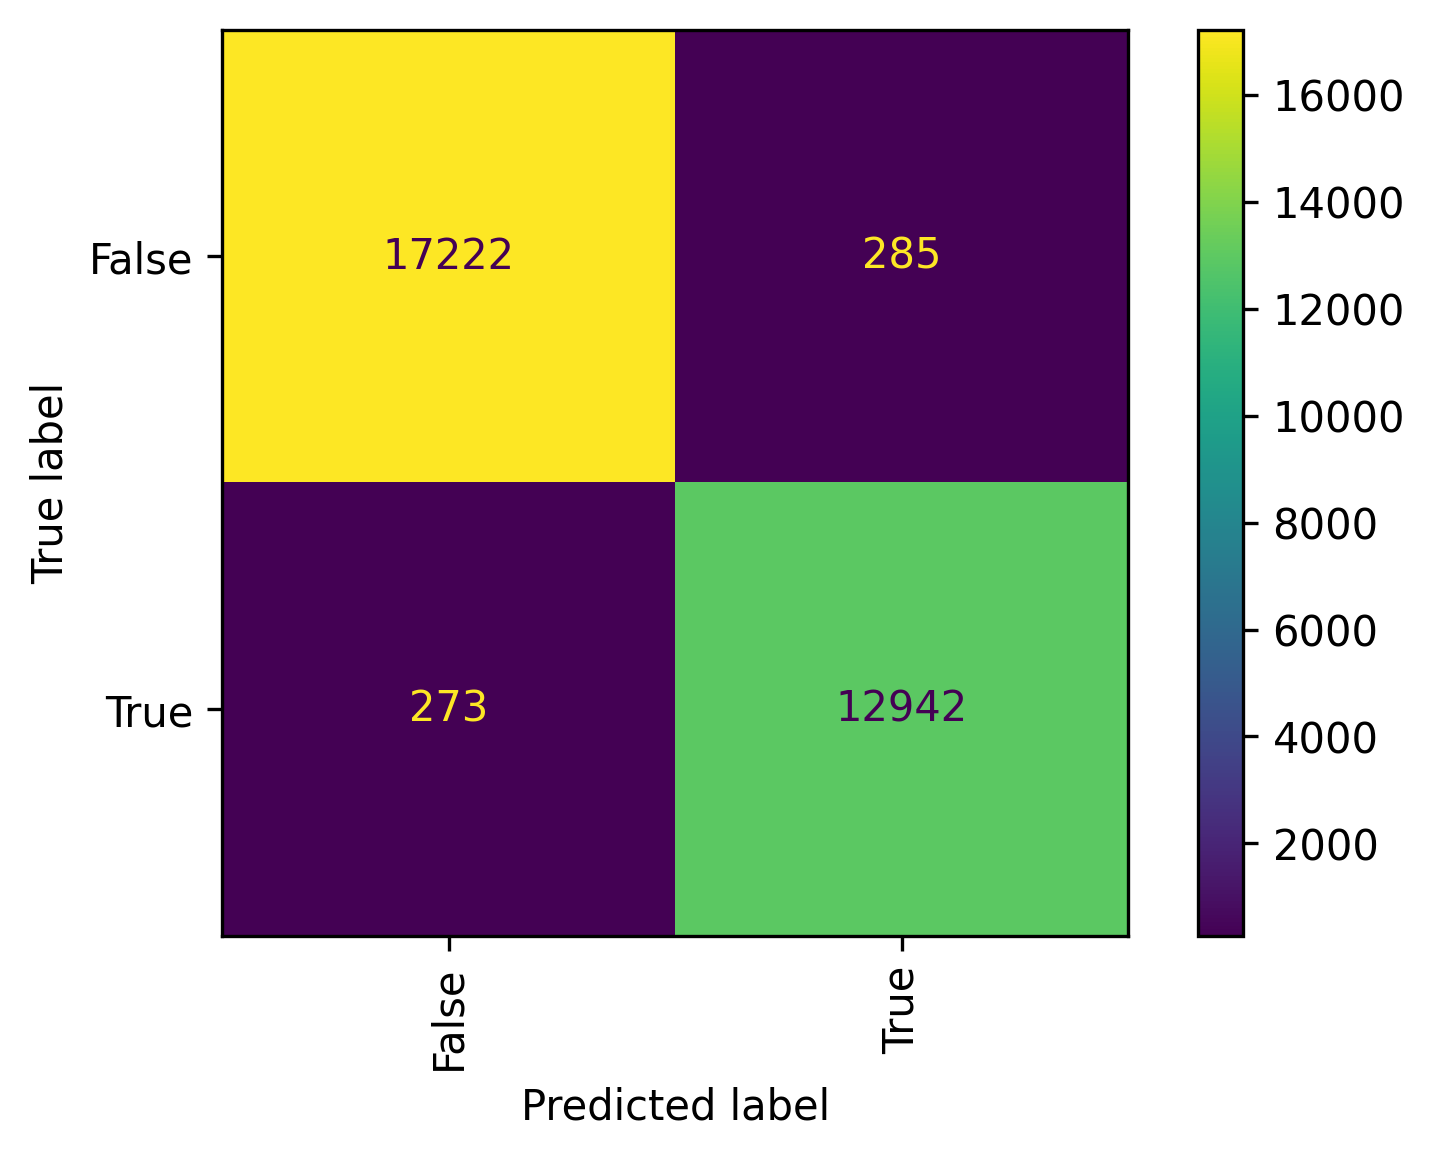

In [24]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

plt.rcParams['figure.dpi'] = 300

plot_confusion_matrix(pipeline, X_val, y_val, values_format='.0f', xticks_rotation='vertical');

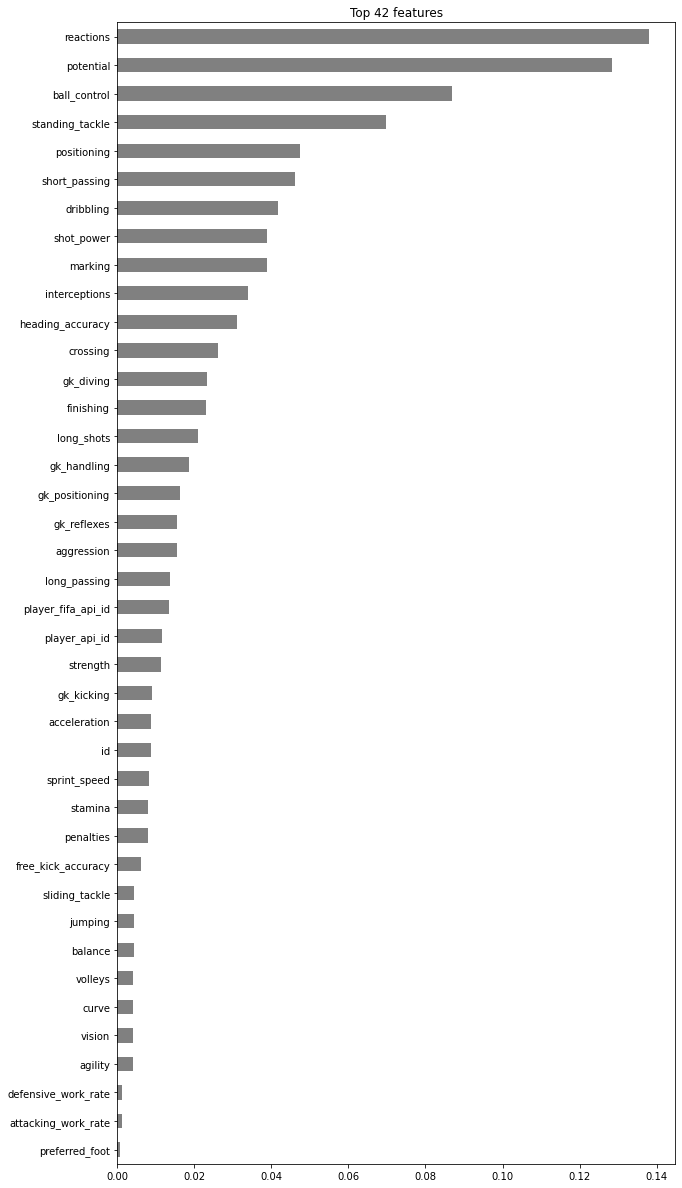

In [25]:
# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 42
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [26]:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [27]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model, 
    scoring='accuracy', 
    n_iter=5, 
    random_state=42
)
permuter.fit(X_val_transformed, y_val)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fr

In [28]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

jumping               -0.000085
attacking_work_rate   -0.000065
preferred_foot        -0.000020
vision                -0.000020
balance               -0.000020
gk_kicking            -0.000007
volleys               -0.000007
agility                0.000020
penalties              0.000020
defensive_work_rate    0.000033
free_kick_accuracy     0.000033
curve                  0.000150
sliding_tackle         0.000176
player_api_id          0.000293
id                     0.000319
player_fifa_api_id     0.000352
stamina                0.000371
long_passing           0.000508
long_shots             0.000710
strength               0.000736
acceleration           0.000762
aggression             0.000937
sprint_speed           0.001042
gk_reflexes            0.002103
gk_handling            0.002597
short_passing          0.003672
gk_positioning         0.003880
interceptions          0.003919
shot_power             0.003919
gk_diving              0.004323
finishing              0.004889
crossing

In [29]:
# 2. Display permutation importances
eli5.show_weights(
    permuter, 
    top=None, # No limit: show permutation importances for all features
    feature_names=feature_names # must be a list
)

Weight,Feature
0.0940 ± 0.0022,potential
0.0162 ± 0.0012,standing_tackle
0.0131 ± 0.0008,reactions
0.0113 ± 0.0015,ball_control
0.0066 ± 0.0007,positioning
0.0061 ± 0.0009,marking
0.0057 ± 0.0003,heading_accuracy
0.0056 ± 0.0007,dribbling
0.0053 ± 0.0006,crossing
0.0049 ± 0.0009,finishing


In [31]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'reactions'

isolated = pdp_isolate(
    model=pipeline, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


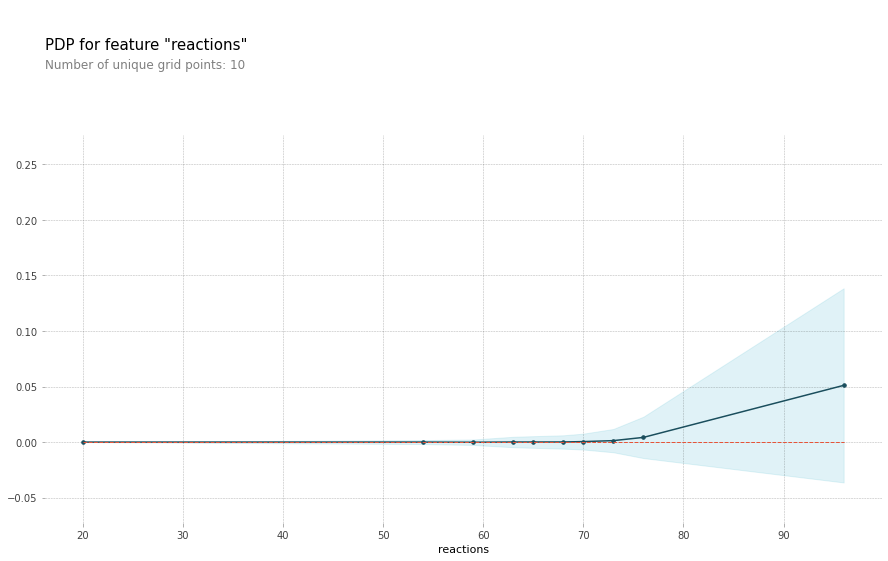

In [50]:
pdp_plot(isolated, feature_name=feature);

In [32]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

In [33]:
features = ['ball_control','reactions']

interaction = pdp_interact(
    model=pipeline, 
    dataset=X_val, 
    model_features=X_val.columns,
    features=features
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


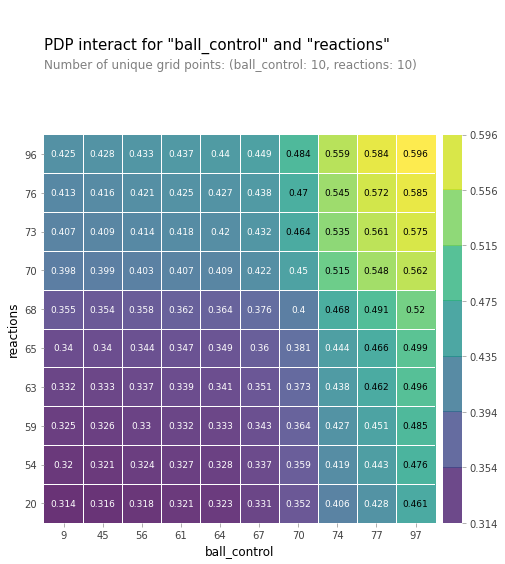

In [34]:
pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

In [ ]:
import shap

explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row, 
    link='logit' # For classification, this shows predicted probabilities
)